## 1 Modeling Volatility and VaR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

In [6]:
df = pd.read_excel('barnstable_analysis_data.xlsx', sheet_name = 'data', index_col = 0)
df.head(2)

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026


For the full sample of SPY returns, 1926-2022, calculate the LEVEL, (not log,) excess market returns (against the treasury returns.) We use this level excess return data throughout this section

In [10]:
df['excess_return'] = df['SPX'] - df['TB1M']
df = df.dropna()
df.shape

(1148, 3)

### 1. Historic VaR.

Starting at t = 61, calculate the historic-based VaR, based on the expanding sample from period 1 (Jan 1926) to t − 1. By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time t − 1. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Denote this as $ \tilde{r}^{VaR,0.5}_{t,historic} $, which is the best estimate of the time-t VaR based on data through
t−1.

- (a) Plot $ \tilde{r}^{VaR,0.5}_{t,historic} $ over time.
- (b) Calculate the frequency of periods in which $ \tilde{r}_t $ < $ \tilde{r}^{VaR,0.5}_{t,historic} $.
- (c) What drawbacks do you see in this historic VaR?

Text(0, 0.5, 'VaR')

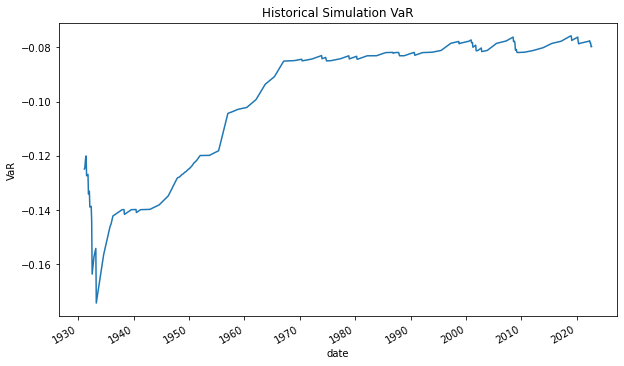

In [14]:
histsim_var = df['excess_return'].shift().expanding(min_periods = 60).quantile(.05)
histsim_var.plot(figsize = (10, 6), title = 'Historical Simulation VaR')
plt.ylabel('VaR')

In [32]:
#Frequency of periods for which r < r_var

#Number of days where excess return is less than VaR divided by total number of Days

frq = round(len(df[df['excess_return']<histsim_var])/len(histsim_var),4)
print ("{:.2%}".format(frq))

2.87%


#### Drawbacks of historical var
- As observed in the 

for dt in dates:
r = level_er.loc[dt-60:dt] #returns
vaR = df_v.loc[dt,vaR]
r[r['er] < var].mean()
df = cv.loc[dt,cvar]=cvar